显示前20张训练集图片及其类别...


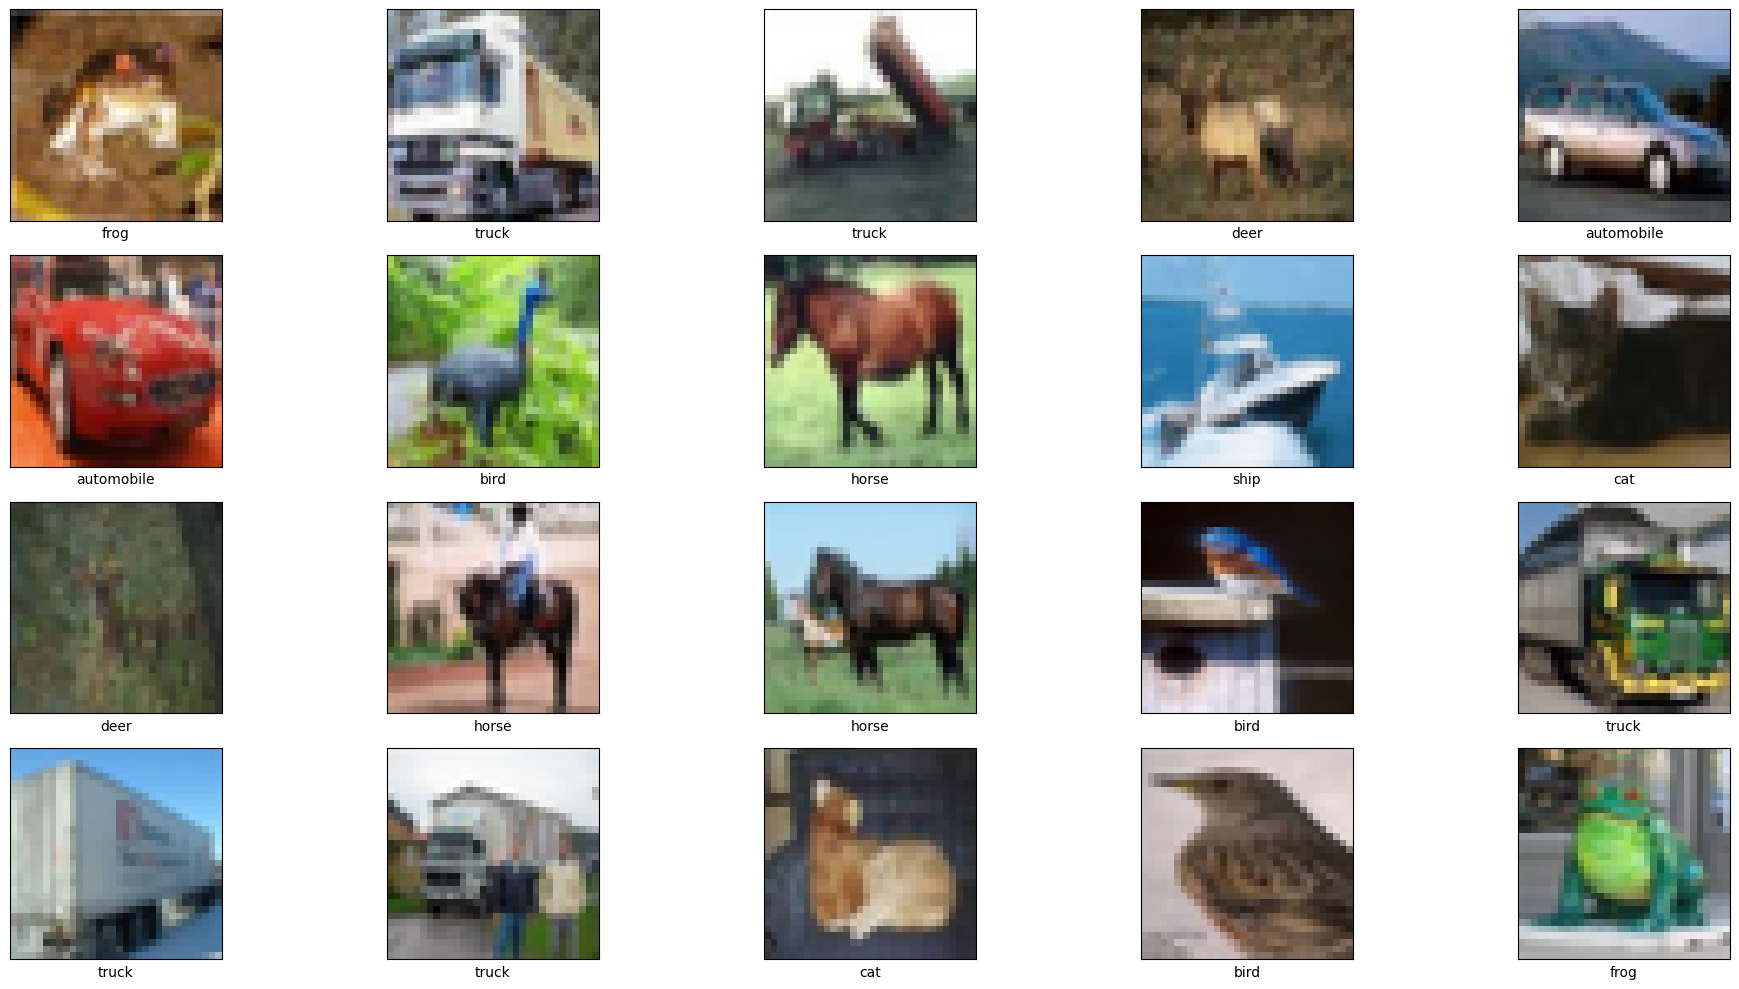

开始处理训练集...
已处理 10000 张图像
已处理 20000 张图像
已处理 30000 张图像
已处理 40000 张图像
已处理 50000 张图像
所有train图像已保存到 cifar10_bin_output/images
标签信息已保存到 cifar10_bin_output/train_labels.csv
显示前20张测试集图片及其类别...


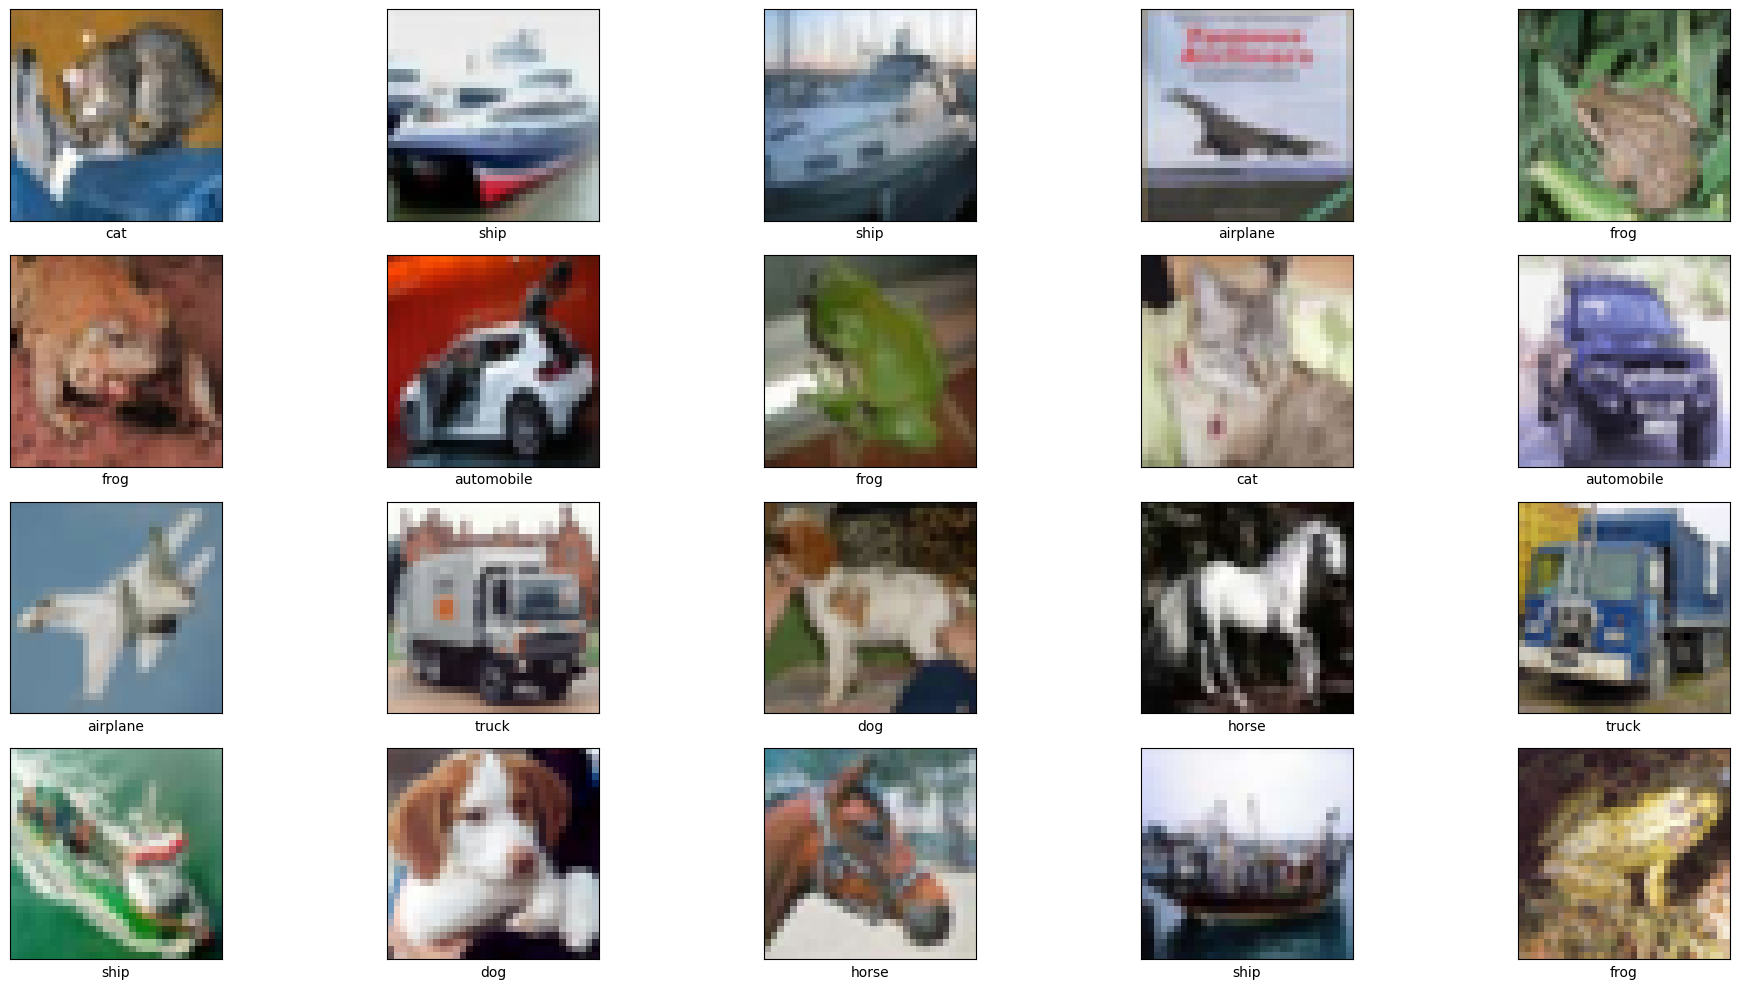

开始处理测试集...
已处理 10000 张图像
所有test图像已保存到 cifar10_bin_output/images
标签信息已保存到 cifar10_bin_output/test_labels.csv
所有数据处理完成！


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import csv
import matplotlib.pyplot as plt

# 定义CIFAR-10的类别名称
CIFAR10_CLASSES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

def create_output_dirs(output_dir):
    """
    创建用于存储二进制图像文件的输出目录
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    images_dir = os.path.join(output_dir, 'images')
    if not os.path.exists(images_dir):
        os.makedirs(images_dir)
    return images_dir

def save_image_to_bin(image, file_path):
    """
    将图像数据保存为二进制文件
    """
    # 确保图像数据类型为uint8
    image = image.astype(np.uint8)
    # 将图像数据按行展开为一维数组
    image_flat = image.flatten()
    # 保存为二进制文件
    image_flat.tofile(file_path)

def generate_bin_files(x_data, y_data, output_dir, dataset_type='train'):
    """
    生成二进制图像文件并记录标签信息
    """
    images_dir = create_output_dirs(output_dir)
    labels_csv = os.path.join(output_dir, f'{dataset_type}_labels.csv')

    with open(labels_csv, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        # 写入CSV头
        csv_writer.writerow(['filename', 'label', 'class_name'])

        for idx, (image, label) in enumerate(zip(x_data, y_data)):
            # 生成唯一的文件名，例如 train_00001.bin
            filename = f'{dataset_type}_{idx+1:05d}.bin'
            file_path = os.path.join(images_dir, filename)
            # 保存图像数据为二进制文件
            save_image_to_bin(image, file_path)
            # 获取类别名称
            class_name = CIFAR10_CLASSES[label]
            # 写入CSV
            csv_writer.writerow([filename, label, class_name])

            if (idx + 1) % 10000 == 0:
                print(f'已处理 {idx+1} 张图像')

    print(f'所有{dataset_type}图像已保存到 {images_dir}')
    print(f'标签信息已保存到 {labels_csv}')

def display_first_20_images(x_data, y_data):
    """
    显示前20张图片及其类别名称
    """
    plt.figure(figsize=(20, 10))
    for i in range(20):
        plt.subplot(4, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_data[i])
        class_name = CIFAR10_CLASSES[y_data[i]]
        plt.xlabel(f"{class_name}")
    plt.tight_layout()
    plt.show()

def main():
    # 加载CIFAR-10数据集
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    # y_train和y_test的形状为 (num_samples, 1)，需要展平为 (num_samples,)
    y_train = y_train.flatten()
    y_test = y_test.flatten()

    # 定义输出目录
    output_dir = 'cifar10_bin_output'

    # 显示前20张训练集图片及其类别
    print('显示前20张训练集图片及其类别...')
    display_first_20_images(x_train, y_train[:20])

    # 生成训练集的二进制文件和标签信息
    print('开始处理训练集...')
    generate_bin_files(x_train, y_train, output_dir, dataset_type='train')

    # 显示前20张测试集图片及其类别
    print('显示前20张测试集图片及其类别...')
    display_first_20_images(x_test, y_test[:20])

    # 生成测试集的二进制文件和标签信息
    print('开始处理测试集...')
    generate_bin_files(x_test, y_test, output_dir, dataset_type='test')

    print('所有数据处理完成！')

if __name__ == '__main__':
    main()


In [ ]:
import os
import numpy as np
import zipfile

def load_image_from_bin(file_path):
    """
    从二进制文件加载图像数据
    """
    # 读取二进制文件
    image_flat = np.fromfile(file_path, dtype=np.uint8)
    # 将一维数组还原为32x32x3的图像
    image = image_flat.reshape((32, 32, 3))
    return image

def save_image_as_header(image, header_file):
    """
    将图像数据保存为C头文件格式的数组
    """
    # 将图像数据转换为C语言数组的格式
    image_flat = image.flatten()
    header_content = f"const uint8_t image[] = {{\n"
    header_content += ", ".join([f"0x{pixel:02X}" for pixel in image_flat])
    header_content += "\n};\n"

    with open(header_file, 'w') as file:
        file.write(header_content)

def convert_bin_to_h(input_dir, output_dir):
    """
    将以'test'开头的二进制图像文件转换为C语言头文件
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 遍历所有以'test'开头的.bin文件
    for filename in os.listdir(input_dir):
        if filename.endswith(".bin") and filename.startswith("test"):
            file_path = os.path.join(input_dir, filename)
            # 加载图像数据
            image = load_image_from_bin(file_path)
            # 生成对应的.h文件
            header_filename = f"{os.path.splitext(filename)[0]}.h"
            header_file_path = os.path.join(output_dir, header_filename)
            save_image_as_header(image, header_file_path)
            print(f"已处理 {filename} -> {header_filename}")

def create_zip_from_directory(directory, zip_filename):
    """
    将指定目录中的所有文件打包为一个ZIP文件
    """
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(directory):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, directory))
    print(f"已将所有.h文件打包成 {zip_filename}")

def main():
    # 设置输入输出目录
    input_dir = 'cifar10_bin_output/images'  # 存储.bin文件的目录
    output_dir = 'cifar10_header_output'  # 输出的.h文件目录
    zip_filename = 'cifar10_header_output.zip'  # ZIP文件名

    # 转换所有以'test'开头的.bin文件为.h文件
    convert_bin_to_h(input_dir, output_dir)

    # 创建ZIP文件
    create_zip_from_directory(output_dir, zip_filename)
    print(f"所有数据处理完成！ZIP文件已保存为 {zip_filename}")

if __name__ == '__main__':
    main()


Streaming output truncated to the last 5000 lines.
已处理 test_04500.bin -> test_04500.h
已处理 test_09399.bin -> test_09399.h
已处理 test_08617.bin -> test_08617.h
已处理 test_05623.bin -> test_05623.h
已处理 test_02369.bin -> test_02369.h
已处理 test_06981.bin -> test_06981.h
已处理 test_07987.bin -> test_07987.h
已处理 test_07112.bin -> test_07112.h
已处理 test_01762.bin -> test_01762.h
已处理 test_08201.bin -> test_08201.h
已处理 test_07383.bin -> test_07383.h
已处理 test_05443.bin -> test_05443.h
已处理 test_00241.bin -> test_00241.h
已处理 test_02742.bin -> test_02742.h
已处理 test_01869.bin -> test_01869.h
已处理 test_09657.bin -> test_09657.h
已处理 test_05789.bin -> test_05789.h
已处理 test_08824.bin -> test_08824.h
已处理 test_03741.bin -> test_03741.h
已处理 test_05932.bin -> test_05932.h
已处理 test_00016.bin -> test_00016.h
已处理 test_04456.bin -> test_04456.h
已处理 test_07309.bin -> test_07309.h
已处理 test_07874.bin -> test_07874.h
已处理 test_08891.bin -> test_08891.h
已处理 test_01574.bin -> test_01574.h
已处理 test_06036.bin -> test_06036.h
已处理 

In [ ]:
import numpy as np
from tensorflow.keras.datasets import cifar10

def save_images_to_header(x_data, output_file='images.h', num_images=1000):
    """
    Save the first `num_images` images as a list of pixel values in hexadecimal format to a header file.
    """
    with open(output_file, 'w') as header_file:
        # Write the header information
        header_file.write("#ifndef IMAGES_H\n")
        header_file.write("#define IMAGES_H\n\n")

        # Start defining the images array
        header_file.write("unsigned char images[][3072] = {\n")

        # Loop through each image and write it in the desired format
        for idx in range(min(num_images, len(x_data))):
            image = x_data[idx]
            # Ensure the image data is in uint8 format
            image = image.astype(np.uint8)
            # Flatten the image to 1D
            image_flat = image.flatten()

            # Write the image as a list of hexadecimal values
            header_file.write("  {")
            row_data = ", ".join([f"0x{byte:02x}" for byte in image_flat])
            header_file.write(f"{{{row_data}}},\n")  # Corrected this line

        # Close the images array and header file
        header_file.write("};\n\n")
        header_file.write("#endif // IMAGES_H\n")

    print(f"Header file {output_file} has been written successfully.")

def main():
    # Load CIFAR-10 dataset
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Define output header file
    output_file = 'images.h'

    # Only use the first 1000 images
    print('Saving the first 1000 images to header file...')
    save_images_to_header(x_train[:100], output_file)

    print('Processing completed!')

if __name__ == '__main__':
    main()


Saving the first 1000 images to header file...
Header file images.h has been written successfully.
Processing completed!


In [ ]:
#define DMA_DEV_ID		XPAR_AXIDMA_0_DEVICE_ID